# Project setup

Import necessary libraries

In [29]:
# System
import os
import shutil
import glob

# Image handling
from PIL import Image, ImageOps

# Numerical
import numpy as np
import pandas as pd
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# CNN
from keras.utils import to_categorical, set_random_seed
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

# Machine Learning
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [30]:
SEED = 42
random.seed(SEED)
set_random_seed(SEED)
np.random.seed(SEED)

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [31]:
INIT_DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

INIT_TRAIN_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Train/Train/')
INIT_TEST_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Test/Test/')

DIR = 'data/'

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [32]:
image_classes = os.listdir(INIT_TRAIN_DIR)

if image_classes == os.listdir(INIT_TEST_DIR):
    print('The same classes are in each folder')
else:
    print('The two folders contain different classes')

The same classes are in each folder


In [33]:
# # image_classes = ['零', '一', '二']
# # image_classes = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十']
# # image_classes = image_classes_train[:20]
# image_classes = random.sample(image_classes, 50)
# # image_classes = image_classes_train

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [34]:
# Remove old data
if os.path.exists(DIR):
    shutil.rmtree(DIR)
    
#Create the new directory
os.mkdir(DIR)
for image_class in image_classes:
    path = os.path.join(DIR, image_class)
    os.makedirs(path)

Now let's combine the train and test data into one directory. This is specified by the `DIR` variable.

In [35]:
def combineDirectories():
    for image_class in image_classes:
        images = []

        # Fetch images from train dir
        train_path = os.path.join(INIT_TRAIN_DIR, image_class)
        images += [os.path.join(train_path, file) for file in os.listdir(train_path)]

        # Fetch images from test dir
        test_path = os.path.join(INIT_TEST_DIR, image_class)
        images += [os.path.join(test_path, file) for file in os.listdir(test_path)]

        # Iterate over the splits and images and copy them to the data directory
        for i, image in enumerate(images):
            new_filename = f"{i+1}.png"
            destination_path = os.path.join(DIR, image_class, new_filename)
            shutil.copy(image, destination_path)
            
combineDirectories()

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [36]:
def checkGrayscale():
    # Loop through each subdirectory and file in the directory
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            if image.lower().endswith('.png'):
                file_path = os.path.join(subdir, image)

                with Image.open(file_path) as img:
                    if img.mode != 'L':
                        print(f"{file_path} is not grayscale.")
            else:
                print("Not a png file: ")
checkGrayscale()

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [37]:
def checkAspectRatios():
    image_sizes = []

    # Iterate through all the images and check if any do not have a 1:1 aspect ratio
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                image_sizes.append(img.size[0])

                if img.size[0] != img.size[1]:
                    print(file_path, img.size)
                    
    return image_sizes
                    
image_sizes = checkAspectRatios()

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 3


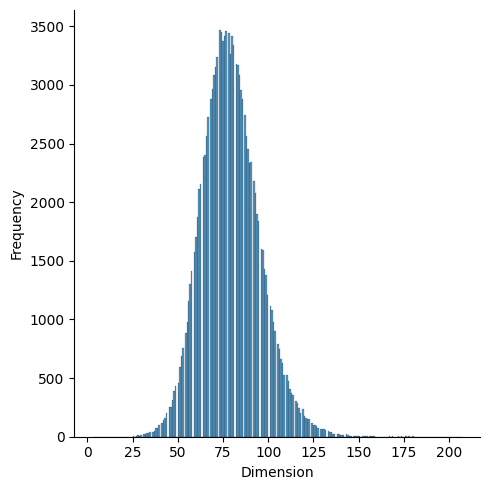

In [38]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
sns.displot(image_sizes)
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will enforce a minimum image size.

In [11]:
MIN_IMAGE_SIZE = 20
IMAGE_SIZE = 48

def resizeImages():
    # Iterate through all the images and resize to a fixed size
    for subdir, dirs, images in os.walk(DIR):
        for image in images:
            file_path = os.path.join(subdir, image)
            with Image.open(file_path) as img:
                current_size = img.size[0]
                if current_size < MIN_IMAGE_SIZE:
                    os.remove(file_path)
                    continue
                
                if current_size != IMAGE_SIZE:
                    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
                
                img = ImageOps.invert(img)
                img.save(file_path)
                
resizeImages()

Now lets check how many images we have in each class and see how balanced the classes are.

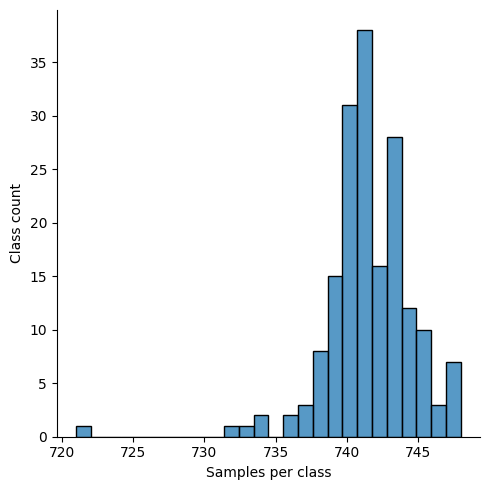

            Count
count  178.000000
mean   741.269663
std      3.031898
min    721.000000
5%     737.000000
25%    740.000000
50%    741.000000
75%    743.000000
95%    746.000000
max    748.000000


In [12]:
def get_class_counts():
    class_counts = {}
    
    for subdir in glob.glob(os.path.join(DIR, '*')):
        file_count = len(glob.glob(os.path.join(subdir, '*')))
        class_counts[subdir.split('/')[-1]] = file_count

    return pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])

df_class_counts = get_class_counts() 

sns.displot(list(df_class_counts['Count']))
plt.xlabel('Samples per class')
plt.ylabel('Class count')
plt.tight_layout()
plt.show()

print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [13]:
df_class_counts = get_class_counts() 

mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

   Count
月    748
零    732
四    734
样    721
老    734
六    733


As we can see, the imbalance is minimal. Because of this, we will not be using any class balancing techniques.

Let's have a look some examples of the images in the dataset.

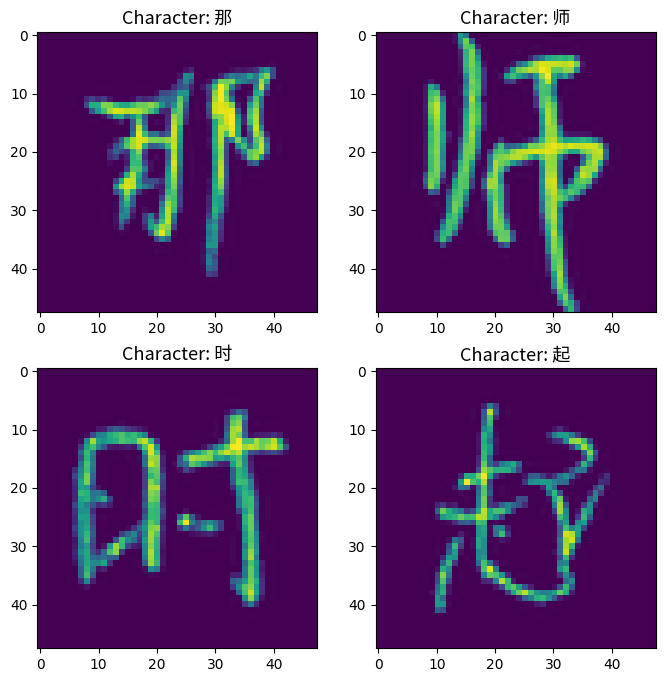

In [14]:
import glob

# Get list of all .png images in the directory and its subdirectories
images = glob.glob(os.path.join(DIR, '**', '*.png'), recursive=True)

# Randomly select num_images images
random_images = random.sample(images, 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Set the font for the plot
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
prop = fm.FontProperties(fname=font_path)

for i in range(2):
    for j in range(2):
        img_path = random_images[2 * i + j]
        img = Image.open(img_path)
        axs[i][j].imshow(img)
        axs[i][j].set_title(f"Character: {img_path.split('/')[1]}", fontproperties=prop,fontsize = 13)

# NumPy Array Conversion

Now we can convert all the images into one single numpy array with the corresponding labels for each image.

In [15]:
def get_numpy_data(classes):
    images = []
    labels = []
    for image_class in classes:
        path = os.path.join(DIR, image_class)
        for image in os.listdir(path):
            image_path = os.path.join(path, image)

            img = Image.open(image_path)
            img_array = np.array(img)

            images.append(img_array)
            labels.append(image_class)
            
    return np.array(images), np.array(labels)

Now we can convert the python lists into numpy arrays.

In [16]:
# random_image_classes = random.sample(image_classes, 50)

images, labels = get_numpy_data(image_classes)

And finally we can save the numpy arrays to the root directory.

In [17]:
np.save('images.npy', images)
np.save('labels.npy', labels)

## CNN Training

In [4]:
images = np.load('images.npy').astype("float32") / 255
labels = np.load('labels.npy')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

def one_hot_encode_labels(y1, y2):
    print(y1)
    print(y2)
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate((y1, y2)))
    
    y1_encoded = label_encoder.transform(y1)
    y2_encoded = label_encoder.transform(y2)
    
    num_classes = len(label_encoder.classes_)
    y1_categorical = to_categorical(y1_encoded, num_classes=num_classes)
    y2_categorical = to_categorical(y2_encoded, num_classes=num_classes)
    
    return y1_categorical, y2_categorical

y_train_ohe, y_test_ohe = one_hot_encode_labels(y_train, y_test)

NUM_CLASSES = y_train_ohe.shape[1]

['很' '小' '同' ... '这' '对' '去']
['高' '怎' '姐' ... '电' '冷' '关']


In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)
print(y_train.shape)
print(y_test.shape)

(105556, 48, 48)
(26390, 48, 48)
(105556, 178)
(26390, 178)
(105556,)
(26390,)


In [7]:
def getCNNModel(hp):
    model = Sequential([
        Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
        
        Conv2D(hp.Int('conv_1_filters', min_value=8, max_value=32, step=8), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_2_filters', min_value=16, max_value=64, step=16), kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)),
        
        Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), kernel_size=2, activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)),
        
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'),
        Dropout(hp.Float('dropout_4', min_value=0.0, max_value=0.7, step=0.1)),
        Dense(units=NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [21]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

tuner = kt.Hyperband(
    getCNNModel,
    objective='val_accuracy',
    max_epochs=15,
    directory='hyperband',
    project_name='cnn_tuning5')

EPOCHS = 30

annealer = LearningRateScheduler(
    lambda x: 1e-3 * 0.99 ** (2 * x))
stop_early = EarlyStopping(
    monitor='loss',
    patience=5)
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True)

tuner.search(
    X_train, y_train_ohe,
    validation_split=0.2,
    callbacks=[annealer, stop_early, checkpoint],
    epochs=EPOCHS, batch_size=128)

Trial 30 Complete [00h 05m 38s]
val_accuracy: 0.9280030131340027

Best val_accuracy So Far: 0.9476127028465271
Total elapsed time: 01h 26m 45s


In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'conv_1_filters': 24, 'dropout_1': 0.0, 'conv_2_filters': 64, 'dropout_2': 0.1, 'conv_3_filters': 128, 'dropout_3': 0.4, 'dense_units': 384, 'dropout_4': 0.2, 'learning_rate': 0.005, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0021'}


In [23]:
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
fold_history = []

for i, (train_idxs, val_idxs) in enumerate(kfold.split(X_train, y_train_ohe)):
    print(f"Fold {i + 1}/{k}")
    
    model = load_model('best_model.h5')
    
    history = model.fit(
        X_train[train_idxs],
        y_train_ohe[train_idxs],
        validation_data=(X_train[val_idxs], y_train_ohe[val_idxs]),
        epochs=15,
        batch_size=64
    )
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch}, Val_accuracy: {max(val_acc_per_epoch)}')
    fold_history.append(history)

Fold 1/5
Epoch 1/15
1320/1320 [==============================] - 24s 18ms/step - loss: 0.4527 - accuracy: 0.8657 - val_loss: 0.2133 - val_accuracy: 0.9427
Epoch 2/15
1320/1320 [==============================] - 24s 18ms/step - loss: 0.4101 - accuracy: 0.8781 - val_loss: 0.2194 - val_accuracy: 0.9391
Epoch 3/15
1320/1320 [==============================] - 24s 18ms/step - loss: 0.3912 - accuracy: 0.8832 - val_loss: 0.2278 - val_accuracy: 0.9372
Epoch 4/15
1320/1320 [==============================] - 24s 18ms/step - loss: 0.3735 - accuracy: 0.8876 - val_loss: 0.2688 - val_accuracy: 0.9220
Epoch 5/15
1320/1320 [==============================] - 24s 18ms/step - loss: 0.3589 - accuracy: 0.8911 - val_loss: 0.2259 - val_accuracy: 0.9362
Epoch 6/15
1320/1320 [==============================] - 24s 18ms/step - loss: 0.3456 - accuracy: 0.8945 - val_loss: 0.2368 - val_accuracy: 0.9324
Epoch 7/15
1320/1320 [==============================] - 24s 18ms/step - loss: 0.3339 - accuracy: 0.8998 - val_loss:

In [6]:
full_model = load_model('best_model.h5')
feature_model = Model(inputs=full_model.input, outputs=full_model.layers[-4].output)

train_features = feature_model.predict(X_train)
test_features = feature_model.predict(X_test)

825/825 [==============================] - 2s 2ms/step


In [7]:
print(train_features.shape)

(105556, 2048)


In [26]:
logistic_regressor = LogisticRegression(solver='lbfgs', max_iter=2000, verbose=1, n_jobs=-1)
logistic_regressor.fit(train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       364722     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46968D+05    |proj g|=  1.42853D+03


 This problem is unconstrained.



At iterate   50    f=  3.27623D+03    |proj g|=  1.51607D+01

At iterate  100    f=  2.31434D+03    |proj g|=  3.56976D+00

At iterate  150    f=  2.20039D+03    |proj g|=  8.18258D-01

At iterate  200    f=  2.19173D+03    |proj g|=  2.61294D-01

At iterate  250    f=  2.19076D+03    |proj g|=  1.84372D-01

At iterate  300    f=  2.19023D+03    |proj g|=  1.74695D-01

At iterate  350    f=  2.18798D+03    |proj g|=  1.05793D+00

At iterate  400    f=  2.18549D+03    |proj g|=  1.10663D+00

At iterate  450    f=  2.18499D+03    |proj g|=  1.11940D-01

At iterate  500    f=  2.18493D+03    |proj g|=  8.84021D-02

At iterate  550    f=  2.18491D+03    |proj g|=  7.87202D-02

At iterate  600    f=  2.18480D+03    |proj g|=  1.05857D-01

At iterate  650    f=  2.18468D+03    |proj g|=  6.27128D-02

At iterate  700    f=  2.18466D+03    |proj g|=  2.40350D-02

At iterate  750    f=  2.18466D+03    |proj g|=  2.01169D-02

At iterate  800    f=  2.18466D+03    |proj g|=  1.86884D-02

At iter

LogisticRegression(max_iter=2000, n_jobs=-1, verbose=1)

In [27]:
log_predictions = logistic_regressor.predict(test_features)

In [28]:
report = classification_report(y_test, log_predictions, digits=4)
print(report)

              precision    recall  f1-score   support

           一     1.0000    0.9865    0.9932       148
           七     0.9366    0.9500    0.9433       140
           三     0.9581    0.9756    0.9668       164
           上     0.9387    0.9684    0.9533       158
           下     0.9675    0.9675    0.9675       154
           不     0.9397    0.9478    0.9437       115
           东     0.9394    0.8857    0.9118       140
           个     0.9643    0.9759    0.9701       166
           中     0.9448    0.9771    0.9607       175
           么     0.9189    0.9855    0.9510       138
           九     0.9673    0.9548    0.9610       155
           习     0.9371    0.9933    0.9644       150
           书     0.9456    0.9653    0.9553       144
           买     0.9493    0.9493    0.9493       138
           了     0.9571    0.9811    0.9689       159
           二     0.9349    0.9875    0.9605       160
           五     0.9517    0.9139    0.9324       151
           些     0.9716    

In [16]:
f1s = []
accuracys = []

for i in range(2, 50, 1):
    # Create an instance of the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean", n_jobs=-1)

    # Fit the classifier to the training data
    knn.fit(train_features, y_train)
    
    # Predict the labels for the test data
    knn_predictions = knn.predict(test_features)
    
    # Calculate the accuracy score
    accuracys.append(accuracy_score(y_test, knn_predictions))

    # Calculate the f1 score
    f1s.append(f1_score(y_test, knn_predictions, average='weighted'))
    
    print(f"k={i}, {accuracys[-1]}, {f1s[-1]}")

k=2, 0.8037514209928003, 0.8042642614055089
k=3, 0.838688897309587, 0.840058339865031
k=4, 0.8445623342175066, 0.8458555420361097
k=5, 0.854225085259568, 0.8555136236323593
k=6, 0.8560060629026146, 0.8573227247112641
k=7, 0.858128078817734, 0.8593422177206598
k=8, 0.8593027661993179, 0.8606883608279599
k=9, 0.8608942781356574, 0.8623629649024004
k=10, 0.8620689655172413, 0.86373789574608
k=11, 0.8624100037893141, 0.8639589214191885
k=12, 0.8620689655172413, 0.8636604790267088
k=13, 0.8619931792345585, 0.8636559064193484
k=14, 0.8607427055702918, 0.8624339736818611
k=15, 0.8610458507010231, 0.8627462696363104
k=16, 0.8605153467222433, 0.8622680770122433
k=17, 0.8610837438423645, 0.8629752411449693
k=18, 0.861311102690413, 0.863287047413952
k=19, 0.8619552860932171, 0.8640016259010177
k=20, 0.8616521409624858, 0.8637585532700727
k=21, 0.8608942781356574, 0.8629967742763404
k=22, 0.8601364153088291, 0.8622354676493081
k=23, 0.8607048124289504, 0.862816765590068
k=24, 0.8608942781356574, 0

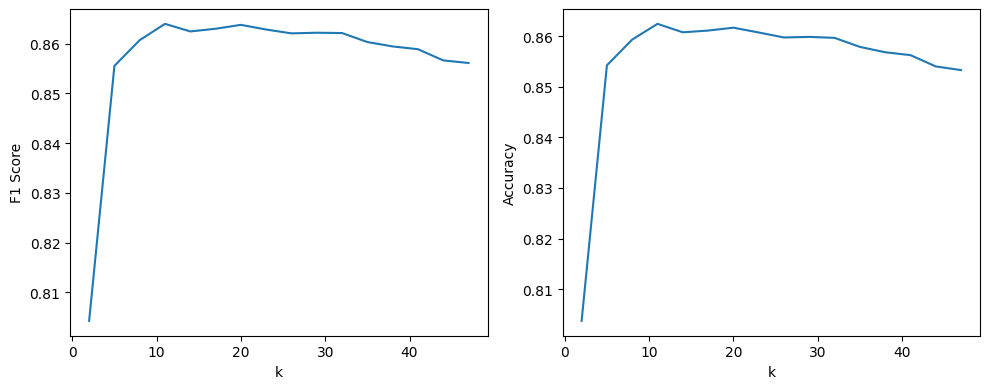

In [17]:
STEP = 3
k_values = range(2, 50, STEP)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(k_values, f1s[::STEP])
ax1.set_xlabel('k')
ax1.set_ylabel('F1 Score')

ax2.plot(k_values, accuracys[::STEP])
ax2.set_xlabel('k')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
rf.fit(train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.8s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [15]:
rf_score = rf.score(test_features, y_test)
print(f"Random Forest Accuracy: {rf_score}")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


Random Forest Accuracy: 0.8707086017430845


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create an instance of the SVM classifier
svm_classifier = SVC()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=2, verbose=1)

# Fit the classifier to the training data using grid search
grid_search.fit(train_features, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [9]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9421918223502217


In [10]:
# Predict the labels for the test data using the best estimator
svm_predictions = grid_search.best_estimator_.predict(test_features)

In [11]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, svm_predictions)

# Calculate the f1 score
f1 = f1_score(y_test, svm_predictions, average='weighted')

# Print the accuracy and f1 score report
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.951951496779083
F1 Score: 0.9520046665214275
